In [4]:
%pylab inline
import psycopg2
from pyiem.network import Table as NetworkTable
import pandas as pd
ASOS = psycopg2.connect(database='asos', user='nobody',host='localhost', port=5555)
acursor = ASOS.cursor()

MESOSITE = psycopg2.connect(database='mesosite', user='nobody', host='iemdb')
mcursor = MESOSITE.cursor()

networks = ['AWOS',]
mcursor.execute("""SELECT distinct network from stations where country = 'US' and 
 network ~* 'ASOS' and length(id) < 4""")
for row in mcursor:
    networks.append( row[0] )

#nt = network.Table(('IA_ASOS','MO_ASOS','IL_ASOS', 'ND_ASOS', 'AWOS',
#          'WI_ASOS','MN_ASOS', 'SD_ASOS', 'NE_ASOS', 'KS_ASOS',
#          'IN_ASOS','KY_ASOS','OH_ASOS','MI_ASOS'))
#nt = network.Table(('IA_ASOS', 'AWOS'))
nt = NetworkTable(networks)
rows = []
sids = nt.sts.keys()
sids.sort()
for sid in sids:
    if nt.sts[sid]['archive_begin'] is None or nt.sts[sid]['archive_begin'].year > 1973:
        continue

    # Figure out what our archive coverage is, 41 years would be perfect
    acursor.execute("""
    select yr from 
        (SELECT substring(d, 1, 4) as yr, count(*) from 
            (select distinct to_char(valid, 'YYYYmmddHH24') as d from alldata 
            where station = %s and valid > '1973-01-01') as foo 
        GROUP by yr) as foo2 
    WHERE count > (365. * 24 * .9)
    """, (sid,) )
    if acursor.rowcount < 37:
        print 'Skipping %s, due to only have %s/41 years of data' % (sid, acursor.rowcount)
        continue
        
    # Compute climatology, 44 years
    acursor.execute("""
 select sum(valid - lag) from 
 (select valid, lag(valid) OVER (ORDER by valid ASC), tmpf from alldata 
 where station = %s and valid < '2016-09-01' and valid > '1972-09-01'
 and tmpf is not null) as foo 
 WHERE tmpf < -0.49 
    """, (sid,))
    row = acursor.fetchone()
    if row[0] is None:
        continue
    climate = ((row[0].days * 86400. + row[0].seconds) / 86400.0) / 44.0
        
    acursor.execute("""
 select sum(valid - lag) from 
 (select valid, lag(valid) OVER (ORDER by valid ASC), tmpf from alldata 
 where station = %s and valid > '2016-09-01' and tmpf is not null) as foo 
 WHERE tmpf < -0.49 
    """, (sid,))
    
    row = acursor.fetchone()
    if row[0] is None:
        delta = 0
    else:
        delta = (row[0].days * 86400. + row[0].seconds) / 86400.0
    rows.append( dict(sid=sid, lat=nt.sts[sid]['lat'], lon=nt.sts[sid]['lon'], val=delta,
                      climate=climate, network=nt.sts[sid]['network']))
    print sid, delta, climate

df = pd.DataFrame(rows)

Populating the interactive namespace from numpy and matplotlib
Skipping 1V4, due to only have 20/41 years of data
Skipping 3A1, due to only have 12/41 years of data
Skipping 3A6, due to only have 2/41 years of data
Skipping 3DU, due to only have 0/41 years of data
Skipping 4BL, due to only have 0/41 years of data
Skipping 4CR, due to only have 0/41 years of data
Skipping 4HV, due to only have 0/41 years of data
Skipping 4SL, due to only have 0/41 years of data
Skipping 79J, due to only have 10/41 years of data
Skipping 87Q, due to only have 18/41 years of data
Skipping AAF, due to only have 26/41 years of data
ABE 0 0.243371212121
ABI 0 0.0123106060606
ABQ 0 0.0208333333333
ABR 13.1118055556 15.7714962121
ABY 0 0.000931186868687
Skipping ACB, due to only have 26/41 years of data
Skipping ACK, due to only have 22/41 years of data
ACT 0 0.00378787878788
ACV 0 0.00153093434343
ACY 0 0.160984848485
Skipping ADM, due to only have 10/41 years of data
ADW 0 0.0350378787879
Skipping AEX, due t

In [5]:
df['ratio'] = df.val / df.climate

In [7]:
df[df.network=='OK_ASOS'].sort(['ratio'])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,climate,lat,lon,network,sid,val,ratio
316,0.102273,36.19839,-95.88811,OK_ASOS,TUL,0.000000,0.000000
262,0.347633,36.73000,-97.10000,OK_ASOS,PNC,0.083333,0.239717
111,0.362895,36.29554,-99.77642,OK_ASOS,GAG,0.291667,0.803723
129,0.064394,34.99131,-99.05139,OK_ASOS,HBR,0.125000,1.941176
224,0.051136,35.38890,-97.60060,OK_ASOS,OKC,0.125000,2.444444
198,0.038826,34.88222,-95.78306,OK_ASOS,MLC,0.125000,3.219512


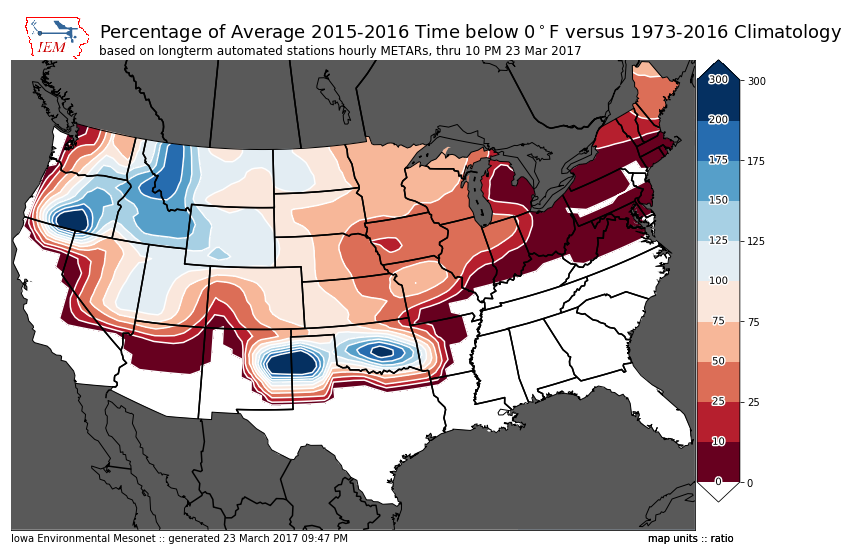

In [17]:
#df = pd.DataFrame(rows)
df2 = df[df.ratio<10]

from pyiem.plot import MapPlot
import numpy as np

m = MapPlot(sector='conus', title="Percentage of Average 2015-2016 Time below 0$^\circ$F versus 1973-2016 Climatology",
            subtitle="based on longterm automated stations hourly METARs, thru 10 PM 23 Mar 2017")
cmap = plt.get_cmap('RdBu')
cmap.set_under('white')
cmap.set_bad('white')
m.contourf(np.array(df2.lon), np.array(df2.lat), np.array(df2['ratio']) * 100.,
           [0, 10, 25, 50, 75, 100, 125, 150, 175, 200, 300], 
           units='%', cmap=cmap)
#m.plot_values(df2.lon, df2.lat, df2.val / df2.climate, fmt='%.1f')
m.postprocess(filename='conus.png')